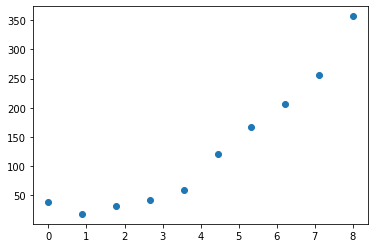

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon
# generate data
n = 10
sigma = 15
data = pd.DataFrame(columns=['x', 'y'])
data['x'] = np.linspace(0, 8, n)
k = -2.4
k2 = 5.2
c = 23
data['y'] = k2*data['x']**2 + k*data['x'] + c + np.random.randn(n)*sigma
# plot data
plt.scatter(data['x'], data['y'])

In [2]:
# form combinations of parameters and define their priors
from itertools import product

# create parameter space for slope and intercept
resolution = 80
data_slope = np.linspace(-10, 10, num=resolution)
data_slope2 = np.linspace(-10, 10, num=resolution)
data_inter = np.linspace(-50, 50, num=resolution)
data_sigma = np.linspace(0.001, 50, num=resolution)

# create dataframe for parameters
df = pd.DataFrame(columns=['slope', 'slope2', 'intercept', 'sigma', 'prior'])
# parameter combinations
comb =list(product(data_slope, data_slope2, data_inter, data_sigma))
temp = pd.DataFrame(data=comb, columns=['slope', 'slope2', 'intercept', 'sigma'])

df['slope'] = temp['slope']
df['slope2'] = temp['slope']
df['intercept'] = temp['intercept']
df['sigma'] = temp['sigma']
slope_prior = norm(3, 1).pdf(df['slope'])
slope_prior2 = norm(1, 1).pdf(df['slope2'])
intercept_prior = norm(20, 5).pdf(df['intercept'])
sigma_prior = expon(0, 10).pdf(df['sigma'])
df['prior'] = slope_prior*slope_prior2*intercept_prior*sigma_prior
df.head()


,slope,slope2,intercept,sigma,prior
0,-10.0,-10.0,-50.0,0.001000,3.716701e-109
1,-10.0,-10.0,-50.0,0.633899,3.488761e-109
2,-10.0,-10.0,-50.0,1.266797,3.274800e-109
3,-10.0,-10.0,-50.0,1.899696,3.073961e-109
4,-10.0,-10.0,-50.0,2.532595,2.885439e-109


In [3]:
# form temporary table for parameters and data
# temp indexes for full join
data['temp'] = 1
df['temp'] = 1

# save old indexes before join
df['org_idx'] = df.index
# full join
df = pd.merge(df, data, on=['temp'])
df.head()

,slope,slope2,intercept,sigma,prior,temp,org_idx,x,y
0,-10.0,-10.0,-50.0,0.001,3.716701e-109,1,0,0.000000,38.114159
1,-10.0,-10.0,-50.0,0.001,3.716701e-109,1,0,0.888889,18.449007
2,-10.0,-10.0,-50.0,0.001,3.716701e-109,1,0,1.777778,31.394552
3,-10.0,-10.0,-50.0,0.001,3.716701e-109,1,0,2.666667,41.586595
4,-10.0,-10.0,-50.0,0.001,3.716701e-109,1,0,3.555556,59.885847


In [4]:
# calculate likelihoods

df['residual'] = df['y'] - (df['slope2'] * df['x']**2 + df['slope'] * df['x'] + df['intercept'])
df['likelihood'] = norm(0, df['sigma']).pdf(df['residual'])

# group by slope and intercept (=org_idx) to get product of likelihoods per parameters
df = df.groupby(['org_idx'], as_index=False).agg({'slope': 'first', 'slope2':'first', 'intercept': 'first', 'sigma': 'first', 'prior': 'first', 'likelihood': 'prod'})

df.head()

,org_idx,slope,slope2,intercept,sigma,prior,likelihood
0,0,-10.0,-10.0,-50.0,0.001000,3.716701e-109,0.0
1,1,-10.0,-10.0,-50.0,0.633899,3.488761e-109,0.0
2,2,-10.0,-10.0,-50.0,1.266797,3.274800e-109,0.0
3,3,-10.0,-10.0,-50.0,1.899696,3.073961e-109,0.0
4,4,-10.0,-10.0,-50.0,2.532595,2.885439e-109,0.0


In [5]:
# calculate posterior
df['posterior'] = df['prior'] * df['likelihood']
# normalize
df['posterior'] = df['posterior'] / df['posterior'].sum()
df.head()

,org_idx,slope,slope2,intercept,sigma,prior,likelihood,posterior
0,0,-10.0,-10.0,-50.0,0.001000,3.716701e-109,0.0,0.0
1,1,-10.0,-10.0,-50.0,0.633899,3.488761e-109,0.0,0.0
2,2,-10.0,-10.0,-50.0,1.266797,3.274800e-109,0.0,0.0
3,3,-10.0,-10.0,-50.0,1.899696,3.073961e-109,0.0,0.0
4,4,-10.0,-10.0,-50.0,2.532595,2.885439e-109,0.0,0.0


15.82346835443038
15.190569620253164


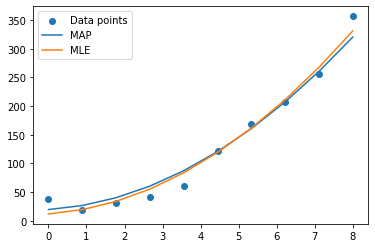

In [6]:
# plot data points
plt.scatter(data['x'], data['y'])
# plot bayes
idx = df['posterior'].argmax()
k = df['slope'][idx]
k2 = df['slope2'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], k2*data['x']**2 + data['x']*k + c)
print(df['sigma'][idx])
# plot max likelihood
idx = df['likelihood'].argmax()
k = df['slope'][idx]
k2 = df['slope2'][idx]
c = df['intercept'][idx]
plt.plot(data['x'], k2*data['x']**2 + data['x']*k + c)
plt.legend(['Data points', 'MAP', 'MLE'])

print(df['sigma'][idx])
